In [65]:
import datetime
import gensim
from gensim import corpora, models, similarities
import math
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
import numpy as np
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import string

In [3]:
tweets = pd.read_csv("./data/london_tweets.csv", encoding="latin1")

In [4]:
tweets.head()

,id,Name,X,Y,LONGITUDE,LATITUDE,MESSAGEDATE,USERID,USERSCREENNAME,MESSAGETEXT,LOCATION,HASHTAGS,ISRETWEET,datetime
0,550226818624942080,NaN,-0.262150,51.391407,-0.262150,51.391407,31/12/2014 09:47:50,113918054,12Elbestreet,@julieo25 Not yet got tics for Liverpool waiti...,Kingston upon Thames,NaN,0,2014-12-31 09:47:50
1,550226827944660992,NaN,-0.014891,51.354042,-0.014891,51.354042,31/12/2014 09:47:53,55872342,MissGee_Pee,If it doesn't make you happy by December 31st....,Croydon,NaN,0,2014-12-31 09:47:53
2,550226837537058816,NaN,0.006698,51.532020,0.006698,51.532021,31/12/2014 09:47:55,147266450,vinita_ramtri,@westfieldstrat thanks; and are you open tomor...,Newham,NaN,0,2014-12-31 09:47:55
3,550227214227505152,NaN,0.214417,51.582535,0.214417,51.582535,31/12/2014 09:49:25,518928608,CallumGordon7,@WestHam_Central but he is,Havering,NaN,0,2014-12-31 09:49:25
4,550227602011856896,NaN,-0.104869,51.509530,-0.104869,51.509529,31/12/2014 09:50:57,151094999,HevnKISZ,@JJJ_Jeeppy >> # XD,Southwark,,0,2014-12-31 09:50:57


In [5]:
tweets.LOCATION.unique()

array(['Kingston upon Thames', 'Croydon', 'Newham', 'Havering',
       'Southwark', 'Hackney', 'Wandsworth', 'Westminster', 'Bexley',
       'Kensington and Chelsea', 'Islington', 'Hillingdon', 'Camden',
       'Barnet', 'Hounslow', 'City of London', 'Ealing', 'Lambeth',
       'Waltham Forest', 'Tower Hamlets', 'Harrow', 'Bromley',
       'Redbridge', 'Brent', 'Greenwich', 'Richmond upon Thames',
       'Enfield', 'Sutton', 'Lewisham', 'Hammersmith and Fulham',
       'Barking and Dagenham', 'Haringey', 'Merton'], dtype=object)

In [6]:
borough_to_cluster = pd.read_csv("./data/borough_to_cluster.csv")

In [7]:
borough_to_cluster.head()

,LOCATION,Cluster
0,Barking and Dagenham,1
1,Barnet,1
2,Bexley,1
3,Brent,2
4,Bromley,1


In [8]:
tweets_by_cluster = tweets.merge(borough_to_cluster, left_on='LOCATION', right_on='LOCATION', how='outer')

In [9]:
tweets_by_cluster.head()

,id,Name,X,Y,LONGITUDE,LATITUDE,MESSAGEDATE,USERID,USERSCREENNAME,MESSAGETEXT,LOCATION,HASHTAGS,ISRETWEET,datetime,Cluster
0,550226818624942080,NaN,-0.262150,51.391407,-0.262150,51.391407,31/12/2014 09:47:50,113918054,12Elbestreet,@julieo25 Not yet got tics for Liverpool waiti...,Kingston upon Thames,NaN,0,2014-12-31 09:47:50,1
1,550228733014331392,NaN,-0.305024,51.427956,-0.305024,51.427956,31/12/2014 09:55:27,275233035,2bcmel,@pjbish hey dude from bude; U 2! Big hugs to t...,Kingston upon Thames,NaN,0,2014-12-31 09:55:27,1
2,550212608746606594,NaN,-0.261681,51.391760,-0.261681,51.391762,31/12/2014 08:51:23,113918054,12Elbestreet,One of the greatest singers of all time good m...,Kingston upon Thames,NaN,0,2014-12-31 08:51:23,1
3,550218811904114688,NaN,-0.298933,51.420210,-0.298933,51.420212,31/12/2014 09:16:01,2463405963,mrsclaireismail,@theshores124 We were planning to go down to B...,Kingston upon Thames,NaN,0,2014-12-31 09:16:01,1
4,550225718060519424,NaN,-0.293391,51.416702,-0.293391,51.416702,31/12/2014 09:43:28,450719269,manda10110,@joemcelderry91 Wishing you Health; Love and ...,Kingston upon Thames,NaN,0,2014-12-31 09:43:28,1


In [10]:
tweets_by_cluster.ISRETWEET.unique()

array([0])

In [11]:
data = tweets_by_cluster[["Cluster", "LOCATION", "MESSAGETEXT", "MESSAGEDATE",]]

In [12]:
data.head()

,Cluster,LOCATION,MESSAGETEXT,MESSAGEDATE
0,1,Kingston upon Thames,@julieo25 Not yet got tics for Liverpool waiti...,31/12/2014 09:47:50
1,1,Kingston upon Thames,@pjbish hey dude from bude; U 2! Big hugs to t...,31/12/2014 09:55:27
2,1,Kingston upon Thames,One of the greatest singers of all time good m...,31/12/2014 08:51:23
3,1,Kingston upon Thames,@theshores124 We were planning to go down to B...,31/12/2014 09:16:01
4,1,Kingston upon Thames,@joemcelderry91 Wishing you Health; Love and ...,31/12/2014 09:43:28


In [13]:
def parse_tweets(tweet):

    tweet = re.sub('@[^\s]+','',tweet).strip()
    tweet = re.sub('#[^\s]+','',tweet).strip()
    tweet = re.sub(r'https?:\/\/.*[\r\n]*','',tweet).strip()
    tweet = " ".join(re.findall("[a-zA-Z0-9]+", tweet))
    
    return tweet

<input>:3: DeprecationWarning: invalid escape sequence \s
<input>:3: DeprecationWarning: invalid escape sequence \s
<input>:3: DeprecationWarning: invalid escape sequence \s
<input>:3: DeprecationWarning: invalid escape sequence \s
<input>:4: DeprecationWarning: invalid escape sequence \s
<input>:3: DeprecationWarning: invalid escape sequence \s
<input>:4: DeprecationWarning: invalid escape sequence \s
<input>:3: DeprecationWarning: invalid escape sequence \s
<input>:4: DeprecationWarning: invalid escape sequence \s
<input>:3: DeprecationWarning: invalid escape sequence \s
<input>:4: DeprecationWarning: invalid escape sequence \s
<input>:3: DeprecationWarning: invalid escape sequence \s
<input>:4: DeprecationWarning: invalid escape sequence \s
<input>:3: DeprecationWarning: invalid escape sequence \s
<input>:4: DeprecationWarning: invalid escape sequence \s
<input>:3: DeprecationWarning: invalid escape sequence \s
<input>:4: DeprecationWarning: invalid escape sequence \s
<input>:3: Dep

In [14]:
data["parsed_tweet"] = data.MESSAGETEXT.apply(lambda tweet: parse_tweets(tweet))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [15]:
data.head()

,Cluster,LOCATION,MESSAGETEXT,MESSAGEDATE,parsed_tweet
0,1,Kingston upon Thames,@julieo25 Not yet got tics for Liverpool waiti...,31/12/2014 09:47:50,Not yet got tics for Liverpool waiting till Fr...
1,1,Kingston upon Thames,@pjbish hey dude from bude; U 2! Big hugs to t...,31/12/2014 09:55:27,hey dude from bude U 2 Big hugs to the family ...
2,1,Kingston upon Thames,One of the greatest singers of all time good m...,31/12/2014 08:51:23,One of the greatest singers of all time good m...
3,1,Kingston upon Thames,@theshores124 We were planning to go down to B...,31/12/2014 09:16:01,We were planning to go down to Bournemouth Fri...
4,1,Kingston upon Thames,@joemcelderry91 Wishing you Health; Love and ...,31/12/2014 09:43:28,Wishing you Health Love and Laughter for 2015 ...


In [16]:
stemmer = PorterStemmer()

def preprocess(tweet):
    
    tweet = tweet.lower()
    tweet = " ".join(re.findall("[a-zA-Z0-9]+", tweet))
    tokens = word_tokenize(tweet)
    tokens = [token for token in tokens if token not in set(stopwords.words('english'))]
    return [stemmer.stem(t) for t in tokens]

In [17]:
data["parsed_tweet"] = data["parsed_tweet"].apply(preprocess)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [18]:
data.parsed_tweet = data.parsed_tweet.apply(lambda t: " ".join(t))
data.head()

/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,Cluster,LOCATION,MESSAGETEXT,MESSAGEDATE,parsed_tweet
0,1,Kingston upon Thames,@julieo25 Not yet got tics for Liverpool waiti...,31/12/2014 09:47:50,yet got tic liverpool wait till friday season ...
1,1,Kingston upon Thames,@pjbish hey dude from bude; U 2! Big hugs to t...,31/12/2014 09:55:27,hey dude bude u 2 big hug famili let catch cof...
2,1,Kingston upon Thames,One of the greatest singers of all time good m...,31/12/2014 08:51:23,one greatest singer time good morn london
3,1,Kingston upon Thames,@theshores124 We were planning to go down to B...,31/12/2014 09:16:01,plan go bournemouth friday saturday forecast s...
4,1,Kingston upon Thames,@joemcelderry91 Wishing you Health; Love and ...,31/12/2014 09:43:28,wish health love laughter 2015 someon special ...


In [19]:
cluster_0 = []

for idx, row in data.iterrows():
    if row["Cluster"] == 0:
        cluster_0.append(row["parsed_tweet"])

cluster_1 = []

for idx, row in data.iterrows():
    if row["Cluster"] == 1:
        cluster_1.append(row["parsed_tweet"])
        
cluster_2 = []

for idx, row in data.iterrows():
    if row["Cluster"] == 2:
        cluster_2.append(row["parsed_tweet"])
        
cluster_3 = []

for idx, row in data.iterrows():
    if row["Cluster"] == 3:
        cluster_3.append(row["parsed_tweet"])
        
cluster_4 = []

for idx, row in data.iterrows():
    if row["Cluster"] == 4:
        cluster_4.append(row["parsed_tweet"])

In [20]:
print(data[data.Cluster == 0].shape)
print(data[data.Cluster == 1].shape)
print(data[data.Cluster == 2].shape)
print(data[data.Cluster == 3].shape)
print(data[data.Cluster == 4].shape)

(15264, 5)
(42961, 5)
(28758, 5)
(9733, 5)
(1062, 5)


In [21]:
print(len(cluster_0))
print(len(cluster_1))
print(len(cluster_2))
print(len(cluster_3))
print(len(cluster_4))

15264
42961
28758
9733
1062


In [35]:
cluster_0

['ill find friend get rape one two',
 'ill probabl die chamc anyway',
 'hous parti',
 'wjat get drunk central see take',
 'tip lingfield barchan plaisir happi new year v',
 'happi birthday hun hope great day xx',
 'let least post address',
 'need vodka',
 'dammit',
 'happi 18th birthday hun hope love day',
 'realli want girl sing old school banger',
 'ta kata cha call u n txt u pani',
 'miss resolut stop buy follow though yeah subtweet',
 'ur alway get onto watch',
 'fam crazyyi cold',
 'kakakkaakkaka',
 'god know becam funni',
 'yesss',
 'got ta treat right got ta cherish life',
 'im alcohol',
 'least someon recogn true abil',
 'cross bike',
 'jacob murphi issu statement',
 'rooood whenev want fatti ur still human tooo',
 '',
 'oh aye',
 'stori mani stori climb structur build higher',
 '',
 'jacket built heater heater insid would nice',
 'im halfway',
 'dock point known troubl maker',
 'tune life',
 'need obama care',
 '',
 'babi mine',
 'happi 18th elswho right besid everi memori hol

In [22]:
texts_0 = [[word for word in document.split()] for document in cluster_0]
texts_1 = [[word for word in document.split()] for document in cluster_1]
texts_2 = [[word for word in document.split()] for document in cluster_2]
texts_3 = [[word for word in document.split()] for document in cluster_3]
texts_4 = [[word for word in document.split()] for document in cluster_4]

In [23]:
dictionary_0 = corpora.Dictionary(texts_0)
dictionary_1 = corpora.Dictionary(texts_1)
dictionary_2 = corpora.Dictionary(texts_2)
dictionary_3 = corpora.Dictionary(texts_3)
dictionary_4 = corpora.Dictionary(texts_4)

In [24]:
corpus_0 = [dictionary_0.doc2bow(text) for text in texts_0]
corpus_1 = [dictionary_1.doc2bow(text) for text in texts_1]
corpus_2 = [dictionary_2.doc2bow(text) for text in texts_2]
corpus_3 = [dictionary_3.doc2bow(text) for text in texts_3]
corpus_4 = [dictionary_4.doc2bow(text) for text in texts_4]

In [25]:
from gensim import corpora, models, similarities

In [26]:
tfidf_0 = models.TfidfModel(corpus_0)
tfidf_1 = models.TfidfModel(corpus_1)
tfidf_2 = models.TfidfModel(corpus_2)
tfidf_3 = models.TfidfModel(corpus_3)
tfidf_4 = models.TfidfModel(corpus_4)

In [27]:
corpus_tfidf_0 = tfidf_0[corpus_0]
corpus_tfidf_1 = tfidf_1[corpus_1]
corpus_tfidf_2 = tfidf_2[corpus_2]
corpus_tfidf_3 = tfidf_3[corpus_3]
corpus_tfidf_4 = tfidf_4[corpus_4]

In [55]:
total_topics = 25 # arbitrary number

In [56]:
lda_0 = models.LdaModel(corpus_0, id2word=dictionary_0, num_topics=total_topics, alpha=0.001)
corpus_lda_0 = lda_0[corpus_tfidf_0]

lda_1 = models.LdaModel(corpus_1, id2word=dictionary_1, num_topics=total_topics, alpha=0.001)
corpus_lda_1 = lda_1[corpus_tfidf_1]

lda_2 = models.LdaModel(corpus_2, id2word=dictionary_2, num_topics=total_topics, alpha=0.001)
corpus_lda_2 = lda_2[corpus_tfidf_2]

lda_3 = models.LdaModel(corpus_3, id2word=dictionary_3, num_topics=total_topics, alpha=0.001)
corpus_lda_3 = lda_3[corpus_tfidf_3]

lda_4 = models.LdaModel(corpus_4, id2word=dictionary_4, num_topics=total_topics, alpha=0.001)
corpus_lda_4 = lda_4[corpus_tfidf_4]

In [71]:
lda_3.log_perplexity(corpus_3)

-9.764987781074035

In [57]:
for lda in [lda_0, lda_1, lda_2, lda_3, lda_4]:
    print(lda.show_topics(total_topics,5))
    print('--------------------')

[(0, '0.029*"nice" + 0.028*"run" + 0.027*"old" + 0.021*"free" + 0.021*"2"'), (1, '0.036*"5" + 0.032*"ye" + 0.023*"even" + 0.020*"loooool" + 0.018*"mate"'), (2, '0.026*"next" + 0.020*"coy" + 0.019*"mourinho" + 0.018*"v" + 0.015*"see"'), (3, '0.057*"2015" + 0.043*"great" + 0.028*"2014" + 0.026*"better" + 0.021*"year"'), (4, '0.035*"day" + 0.034*"good" + 0.029*"3" + 0.028*"j" + 0.024*"tonight"'), (5, '0.052*"get" + 0.028*"man" + 0.024*"birthday" + 0.017*"find" + 0.017*"film"'), (6, '0.058*"go" + 0.040*"na" + 0.028*"gon" + 0.022*"amaz" + 0.020*"ff"'), (7, '0.040*"la" + 0.015*"live" + 0.015*"babi" + 0.014*"lie" + 0.013*"book"'), (8, '0.026*"thought" + 0.021*"alreadi" + 0.020*"never" + 0.018*"fan" + 0.015*"gone"'), (9, '0.025*"hotspur" + 0.024*"like" + 0.022*"tri" + 0.020*"talk" + 0.019*"actual"'), (10, '0.046*"london" + 0.038*"0" + 0.028*"best" + 0.022*"spur" + 0.021*"2015"'), (11, '0.172*"year" + 0.156*"new" + 0.121*"happi" + 0.024*"everyon" + 0.019*"2015"'), (12, '0.043*"fuck" + 0.042*"ka

In [31]:
from collections import OrderedDict

data_lda_0 = {i: OrderedDict(lda_0.show_topic(i,25)) for i in range(total_topics)}

In [32]:
import pandas as pd

df_lda_0 = pd.DataFrame(data_lda_0)
print(df_lda_0.shape)
df_lda_0 = df_lda_0.fillna(0).T
print(df_lda_0.shape)

(104, 5)
(5, 104)


In [33]:
df_lda_0

,0,1,2014,2015,3,alway,arsen,back,best,birthday,...,useless,want,watch,well,white,win,wish,would,x,year
0,0.000000,0.000000,0.00000,0.000000,0.000000,0.003511,0.005587,0.000000,0.000000,0.00000,...,0.00361,0.000000,0.000000,0.000000,0.000000,0.003491,0.00000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.00000,0.008196,0.000000,0.005639,0.000000,0.000000,0.00000,0.004487,0.000000,0.000000
2,0.000000,0.000000,0.00609,0.022535,0.000000,0.000000,0.000000,0.000000,0.007913,0.00372,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00458,0.000000,0.009036,0.074093
3,0.005301,0.008294,0.00000,0.000000,0.007025,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.00000,0.000000,0.000000,0.000000,0.007253,0.000000,0.00000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.004059,0.000000,0.00000,...,0.00000,0.000000,0.007753,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.005637


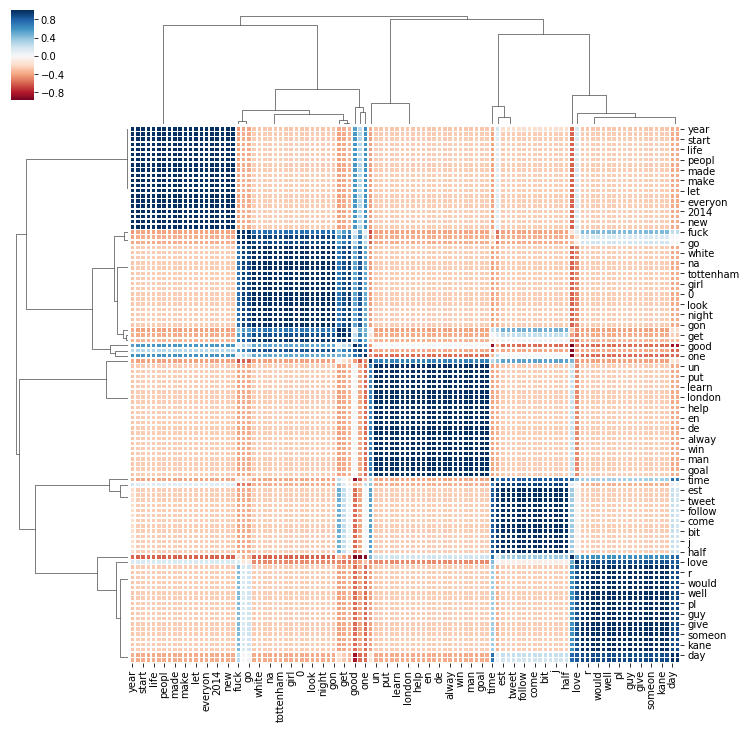

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

g=sns.clustermap(df_lda_0.corr(), center=0, cmap="RdBu", metric='cosine', linewidths=.75, figsize=(12, 12))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()
#plt.setp(ax_heatmap.get_yticklabels(), 

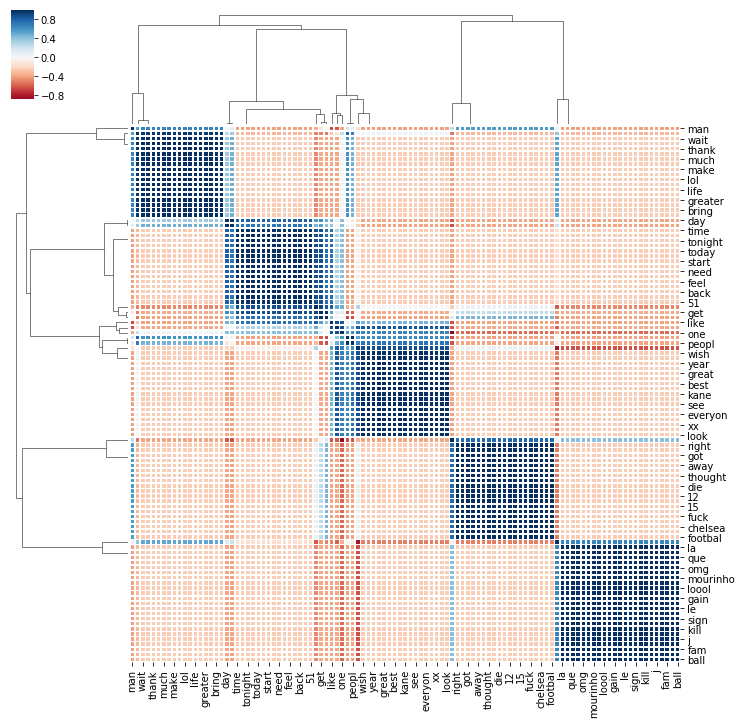

In [35]:
data_lda_1 = {i: OrderedDict(lda_1.show_topic(i,25)) for i in range(total_topics)}

df_lda_1 = pd.DataFrame(data_lda_1)
df_lda_1 = df_lda_1.fillna(0).T

g=sns.clustermap(df_lda_1.corr(), center=0, cmap="RdBu", metric='cosine', linewidths=.75, figsize=(12, 12))
# plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
# plt.setp(rotation=0)
plt.show()

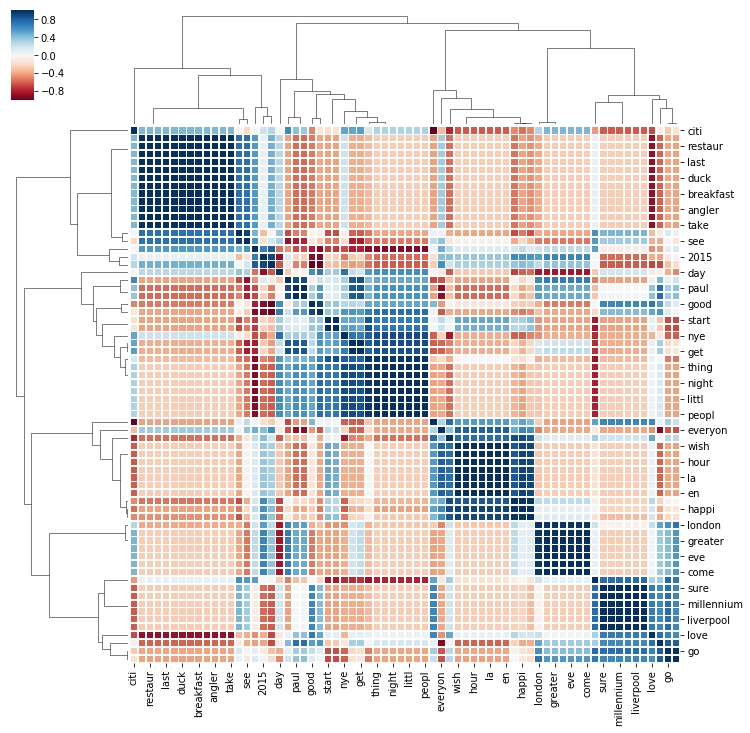

In [36]:
data_lda_4 = {i: OrderedDict(lda_4.show_topic(i,25)) for i in range(total_topics)}

df_lda_4 = pd.DataFrame(data_lda_4)
df_lda_4 = df_lda_4.fillna(0).T

g=sns.clustermap(df_lda_4.corr(), center=0, cmap="RdBu", metric='cosine', linewidths=.75, figsize=(12, 12))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

In [39]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(lda_0, corpus_lda_0, dictionary_0, mds='tsne')
panel

/Users/tom/anaconda3/lib/python3.6/site-packages/joblib/externals/loky/backend/semaphore_tracker.py:74: UserWarning: semaphore_tracker: process died unexpectedly, relaunching.  Some semaphores might leak.
  warnings.warn('semaphore_tracker: process died unexpectedly, '
exception calling callback for <Future at 0x123cdb940 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/Users/tom/anaconda3/lib/python3.6/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/Users/tom/anaconda3/lib/python3.6/site-packages/joblib/parallel.py", line 309, in __call__
    self.parallel.dispatch_next()
  File "/Users/tom/anaconda3/lib/python3.6/site-packages/joblib/parallel.py", line 731, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/Users/tom/anaconda3/lib/python3.6/site-packages/joblib/parallel.py", line 759, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/tom/a

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker. The exit codes of the workers are {EXIT(1)}